Epoch 1: Loss = 0.3045596665546782
Epoch 11: Loss = 0.002875771682804498
Epoch 21: Loss = 0.0009843752163629915
Epoch 31: Loss = 0.00037330463286181723
Epoch 41: Loss = 0.0001711967367747036
Epoch 51: Loss = 9.174327748361578e-05
Epoch 61: Loss = 5.722802205859578e-05
Epoch 71: Loss = 4.0597347658071213e-05
Epoch 81: Loss = 3.228746364765556e-05
Epoch 91: Loss = 2.7808419135375572e-05


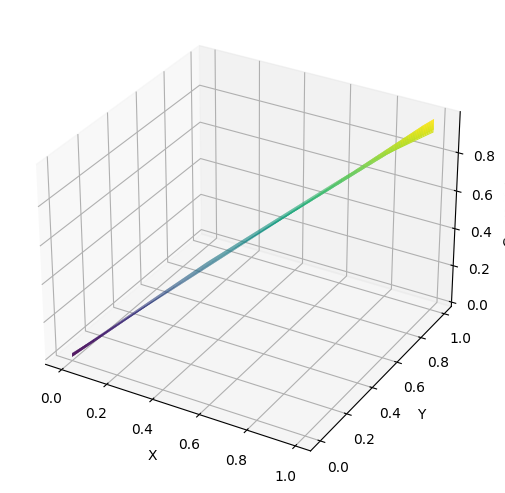

In [53]:
import numpy as np
import torch
import torch.nn as nn

# Step 1: Generate Data
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi * x) + 0.001 * np.random.randn(len(x))

# Step 2: Define your model
class CurveFitter(nn.Module):
    def __init__(self):
        super(CurveFitter, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 3: Define your loss function and optimizer
model = CurveFitter()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Step 4: Train your model
for epoch in range(100):
    running_loss = 0.0
    for i in range(len(x)):
        inputs = torch.tensor([x[i], y[i]], dtype=torch.float32)
        labels = torch.tensor([np.sin(2 * np.pi * x[i])], dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch%10==0: print(f"Epoch {epoch+1}: Loss = {running_loss/len(x)}")

# Step 5: Use your model to predict the curve values
x_test = np.arange(0, 1, 0.01)
y_test = np.arange(0, 1, 0.01)
curve_predictions = []

for i in range(len(x_test)):
    for j in range(len(y_test)):
        inputs = torch.tensor([x_test[i], y_test[j]], dtype=torch.float32)
        prediction = model(inputs).item()
        curve_predictions.append(prediction)

curve_predictions = np.array(curve_predictions).reshape(len(x_test), len(y_test))

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, subplot_kw={'projection':'3d'}, constrained_layout=True)
ax.plot_surface(x_test, y_test, curve_predictions, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Curve Value')
plt.show()
